## Download the dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip -q /content/drive/MyDrive/HuTu80cellpopulationsDataset.zip

Setup path to bcanalyzer sources or install package from pip

In [3]:
import os
import cv2
from matplotlib import pyplot as plt
import numpy as np

In [142]:
def roll(a,      # ND array
         b_shape,      # rolling 2D window array size
         dx=1,   # horizontal step, abscissa, number of columns
         dy=1):  # vertical step, ordinate, number of rows
    shape = a.shape[:-2] + ((a.shape[-2] - b_shape[-2]) // dy + 1,) + ((a.shape[-1] - b_shape[-1]) // dx + 1,) + b_shape
    strides = a.strides[:-2] +(a.strides[-2] * dy,) + (a.strides[-1] * dx,) + a.strides[-2:]
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

In [143]:
def sliding_window(data, win_shape, fcn, dx=1, dy=1):
    n = data.ndim  # number of dimensions
    # np.all over 2 dimensions of the rolling 2D window for 4D array
    result = fcn(roll(data, win_shape, dx, dy), axis=(n, n+1))
    return result

In [6]:
def mean_window(data, axis):
    res = np.sum(data, axis=axis)
    return res

In [7]:
def tile_array(a, b0, b1):
    r, c = a.shape                                    # number of rows/columns
    rs, cs = a.strides                                # row/column strides
    # view a as larger 4D array
    x = np.lib.stride_tricks.as_strided(a, (r, b0, c, b1), (rs, 0, cs, 0))
    return x.reshape(r*b0, c*b1)                      # create new 2D array

In [136]:
def edge_density(mid: np.array,win_size: int,win_step: int = 10,canny_1: float = 41,canny_2: float = 207) -> np.array:
    dxy = win_step
    result = sliding_window(mid, (win_size, win_size),mean_window, dx=dxy, dy=dxy) // ((win_size*win_size))
    result = tile_array(result, dxy, dxy)
    h_pad = img_np.shape[0] - result.shape[0]
    w_pad = img_np.shape[1] - result.shape[1]
    result = np.pad(result, ((h_pad//2, h_pad//2+img_np.shape[0] % 2), (w_pad//2, w_pad//2+img_np.shape[1] % 2)), 'edge')
    return result


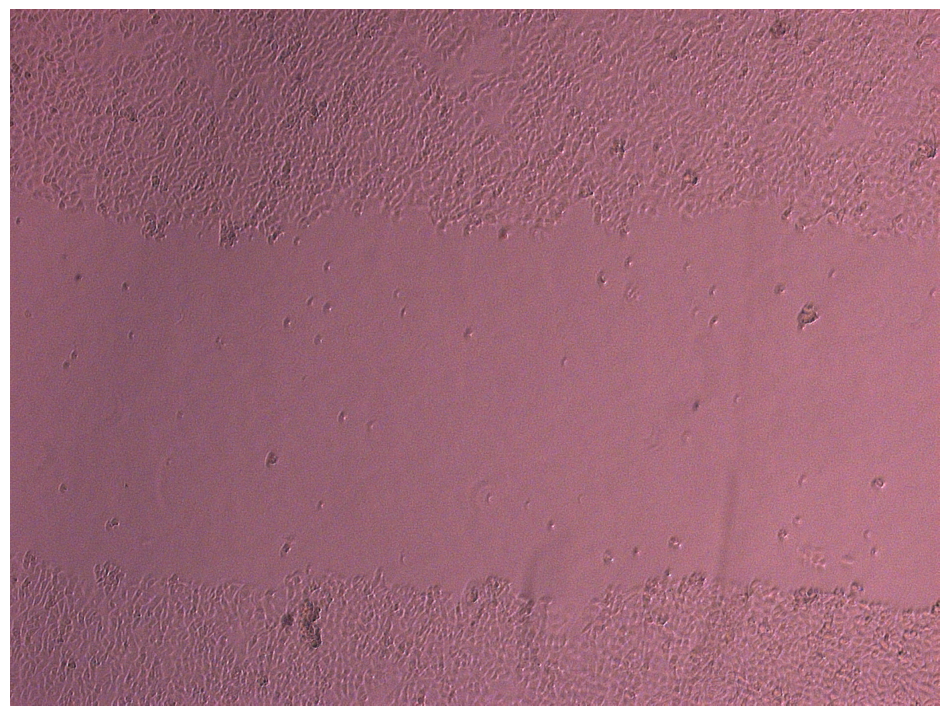

In [150]:
# Load image in cv2 style (BGR)
img_np = cv2.imread("/content/MCF-7 cell populations Dataset/images/0(control)_1_1_040619_0h.png")

plt.figure(figsize=(12,15))
plt.axis('off')
plt.imshow(cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB)) # Convert from BGR to RGB and show image
plt.show()

Convert color image to grayscale, because the algorithm requires a grayscale image for processing.

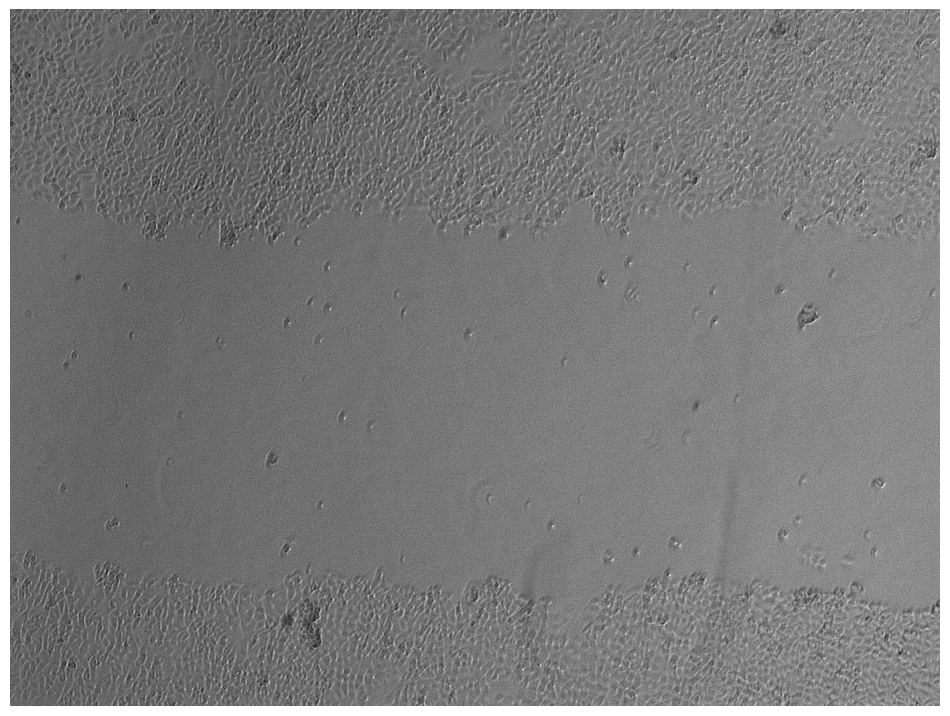

In [151]:
gray_np = cv2.cvtColor(img_np, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(12,15))
plt.axis('off')
plt.imshow(gray_np, cmap="gray")
plt.show()

In [144]:

# win_size=100
# win_step=10

# gray = gray_np.astype(float) / 255.0
# k_size = win_size*3
# bg = cv2.blur(gray, (k_size, k_size))
# gray = gray - bg
# gray -= gray.min()
# gray = (gray * 255).astype(np.uint8)


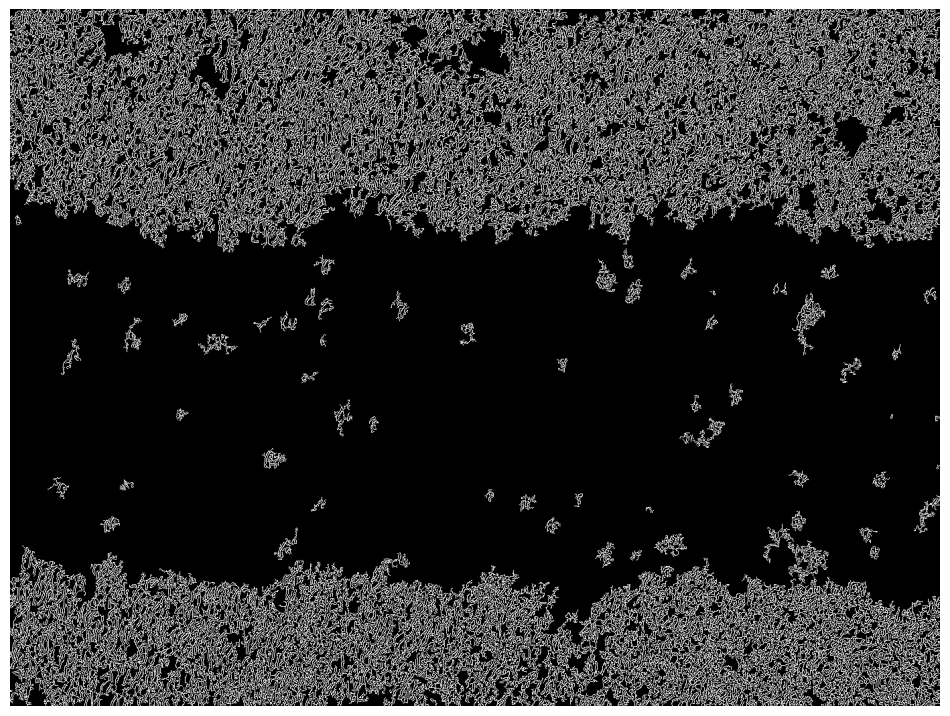

In [152]:
canny_op = cv2.Canny(gray_np, 41, 207)

plt.figure(figsize=(12,15))
plt.axis('off')
plt.imshow(canny_op,cmap="gray") # Convert from BGR to RGB and show image
plt.show()

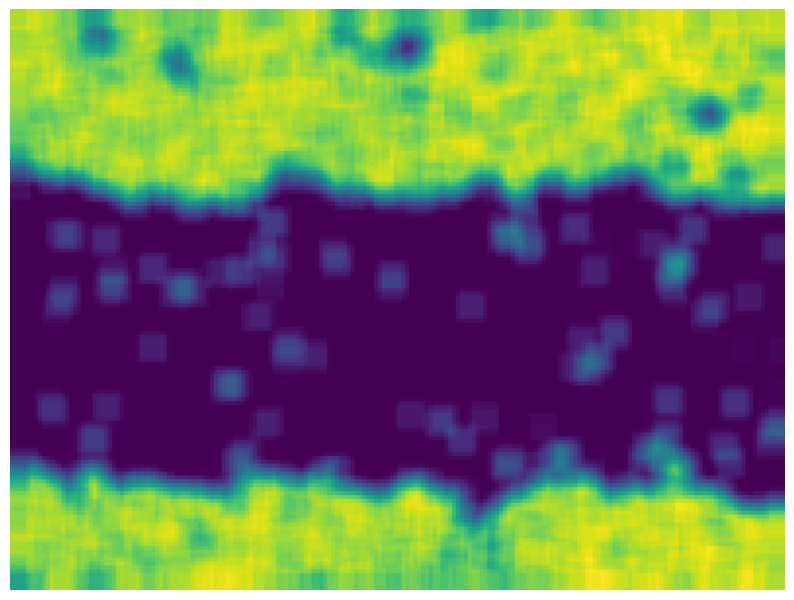

In [153]:
result = edge_density(canny_op,win_size=50,win_step=7)

plt.figure(figsize=(10,12))
plt.axis('off')
plt.imshow(result)
plt.show()

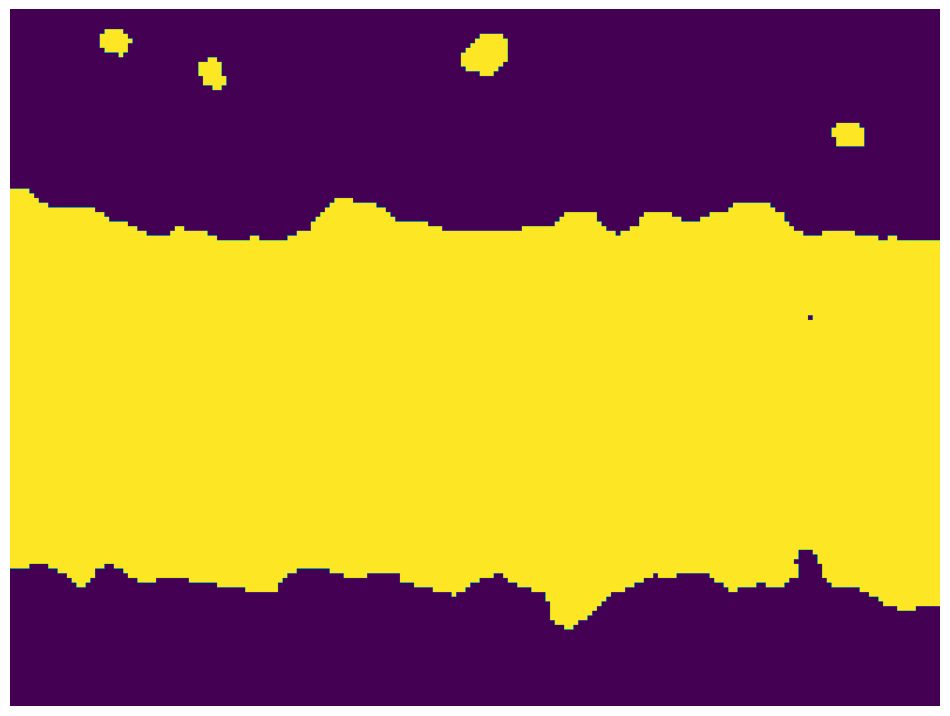

In [154]:
th=50
img_thresh = np.where(result > th, 0, 255).astype(np.uint8)

plt.figure(figsize=(12,15))
plt.axis('off')
plt.imshow(img_thresh)
plt.show()

Estimate edge density with windows size 100 and step 10 (default)

Next, estimate density with different parameters

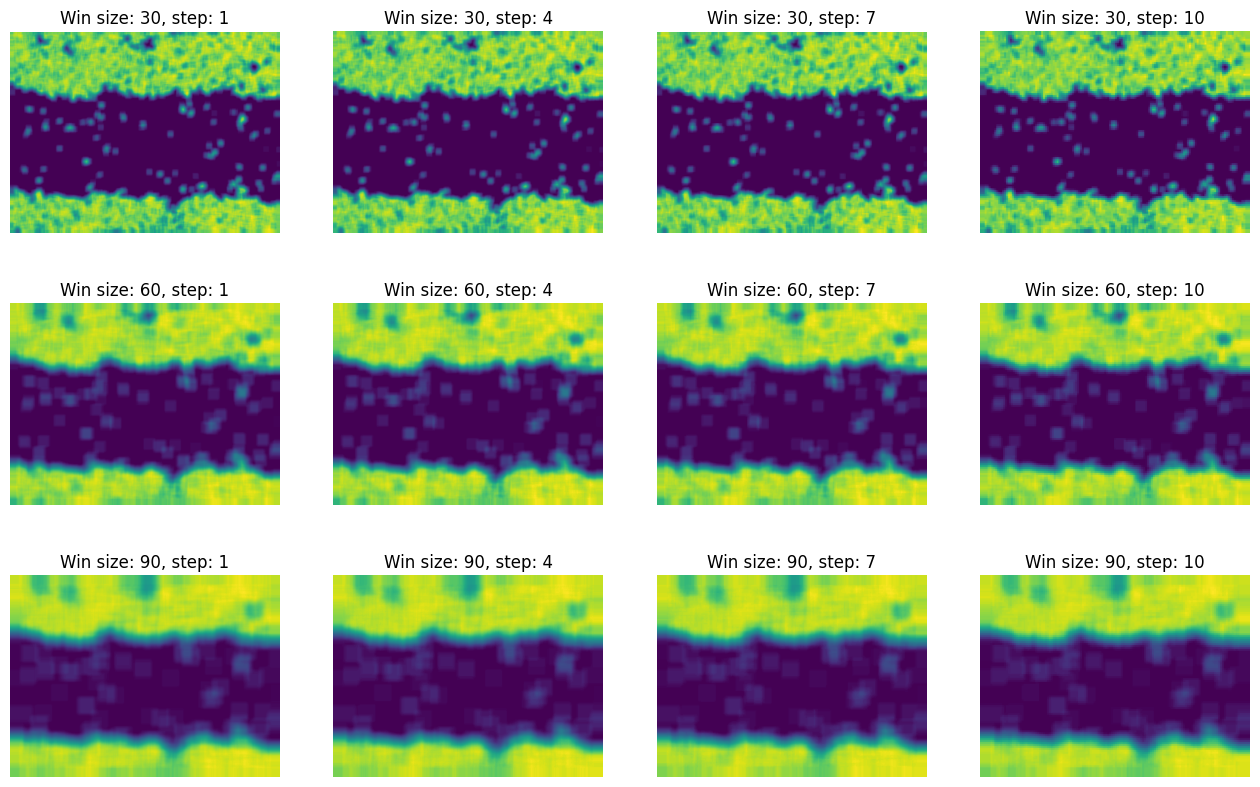

In [155]:
fig, axs = plt.subplots(nrows=3, ncols=4, sharex=True,
                                    figsize=(16, 10))
for row in range(3):
    for col in range(4):
        step_size = col*3 + 1
        win_size = (row+1) * 30
        edges_np = edge_density(canny_op, win_size, step_size)
        axs[row, col].set_title(f'Win size: {win_size}, step: {step_size}')
        axs[row, col].imshow(edges_np)
        axs[row, col].axis('off')

In [157]:
#hyperparameters
th=50 #threshold value
win_size=100
win_step=10
canny1= 41
canny2=207

In [160]:
import os
data_dir='/content/MCF-7 cell populations Dataset/images'
files=os.listdir(data_dir)
os.mkdir('output4')

FileExistsError: ignored

In [102]:
for file in files:
    imagee = cv2.imread(data_dir+"/"+file)
    grayy = cv2.cvtColor(imagee, cv2.COLOR_BGR2GRAY)
    cannyy = cv2.Canny(grayy, canny1, canny2)
    edgee = edge_density(cannyy,win_size,win_step)
    imgtr = np.where(edgee > th, 0, 255).astype(np.uint8)

    inv = 255 - imgtr

    cv2.imwrite('output4/'+file[:len(file)-4]+".png",inv)

In [130]:
def mse(img1, img2):
  h, w = img1.shape
  diff = cv2.subtract(img1, img2)
  err = np.sum(diff**2)
  mse = err/(float(h*w))
  return mse, diff

In [135]:
def findloss(img1,img2):
# convert the images to grayscale
  img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
  img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
# define the function to compute MSE between two images
  error, diff = mse(img1, img2)
  return error,diff

In [134]:
net=0
gt_masks=os.listdir('/content/MCF-7 cell populations Dataset/masks')
op_masks=os.listdir('/content/output4')

for i in range(len(gt_masks)):
    # print(gt_masks[i])
    gt=cv2.imread('/content/MCF-7 cell populations Dataset/masks'+"/"+ gt_masks[i])
    op=cv2.imread('output4'+'/'+ op_masks[i])
    err,diff=findloss(gt,op)
    net+=err
print('TOTAL MSE LOSS OVER DATASET:',net)

TOTAL MSE LOSS OVER DATASET: 12.502743294169802


In [141]:
img = cv2.imread('/content/MCF-7 cell populations Dataset/images/0(control)_1_1_040619_0h.png')
mask = cv2.imread('/content/output4/0(control)_1_1_040619_0h.png',0)
res = cv2.bitwise_and(img,img,mask = mask)

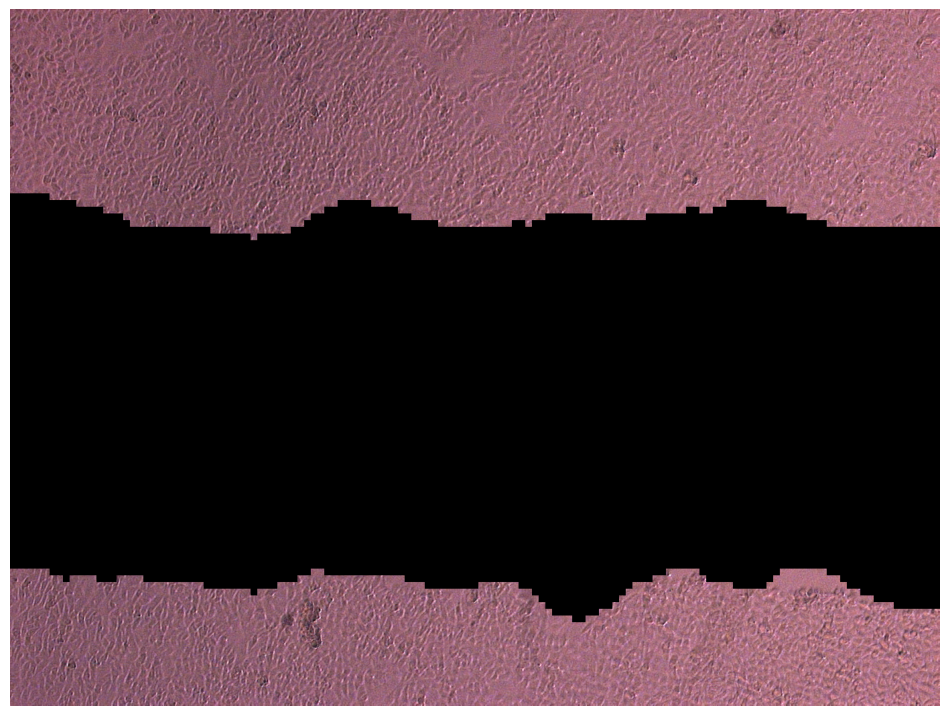

In [139]:
plt.figure(figsize=(12,15))
plt.axis('off')
plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB)) # Convert from BGR to RGB and show image
plt.show()